## Summary

Based on the WiderFace dataset, this code contains a sample of ~12k images with one or more faces. The dataset has been transformed to a format suitable for training a face detection model using the `ultralytics` library.

* Since the images can contain more than one face, and the fact that we need suitable resolution of images for face-generation modules, the images have been filtered to only those with reasonable number of faces, with reasonable area of the face in the image.


In [1]:
import os

bounding_boxes = os.listdir("Data/labels")

print("Original Dataset Size:", len(bounding_boxes))

def contains_too_many_faces(label_file, max_faces=5):
    """
    Check if the bounding boxes contain too many faces.
    """
    
    #get number of lines in the label file
    with open(os.path.join("Data/labels", label_file), 'r') as file:
        lines = file.readlines()
    
    return len(lines) > max_faces

bounding_boxes = [bb for bb in bounding_boxes if not contains_too_many_faces(bb, max_faces=5)]
print("Filtered Dataset Size:", len(bounding_boxes))

Original Dataset Size: 12880
Filtered Dataset Size: 8439


In [2]:
import numpy as np

def get_area_of_faces(label_file):
    """
    Using the normalized bounding boxes, calculate the least area of the face
    """
    with open(os.path.join("Data/labels", label_file), 'r') as file:
        lines = file.readlines()
        bboxes = [list(map(float, line.strip().split()[1:])) for line in lines]
    
    areas = [np.abs((bbox[2] - bbox[0]) * (bbox[3] - bbox[1])) for bbox in bboxes]
    return min(areas) if areas else 0

bbox_areas = {file_name: get_area_of_faces(file_name) for file_name in bounding_boxes}

areas = np.array(list(bbox_areas.values()))
#print quantiles of the areas
quantiles = [0.15, 0.25, 0.3, 0.35, 0.5, 0.75, 0.9, 0.95, 0.99]
for quantile in quantiles:
    print(f"{int(quantile*100)}th quantile: {np.quantile(areas, quantile)*100:.2f}%")

15th quantile: 0.33%
25th quantile: 0.69%
30th quantile: 0.89%
35th quantile: 1.14%
50th quantile: 2.12%
75th quantile: 5.63%
90th quantile: 11.88%
95th quantile: 17.07%
99th quantile: 31.87%


* Since the original images are scaled down to 640x640, then the detections of 1% are going to be 64x64. Anything smaller than that would be discarded. We would need to filter the images by ~4% threshold if we want the faces to be at least 128x128 pixels. However, since this is only a detection model, the size of the face is not critical. Hence only the noisy samples are being removed. Simiarly, the outlying 1% of the images with more than 30% of the image area occupied by faces are also removed.

In [3]:
bbox_areas = {file_name: area for file_name, area in bbox_areas.items() if (area > 0.01) & (area <0.3187)}
bounding_boxes = list(bbox_areas.keys())
print("Final Dataset Size:", len(bounding_boxes))

Final Dataset Size: 5627


In [4]:
import shutil
label_path ="Data/labels"
image_path = "Data/images"

filtered_labels = "Data/filtered_labels"
filtered_images = "Data/filtered_images"
os.makedirs(filtered_labels, exist_ok=True)
os.makedirs(filtered_images, exist_ok=True)

for filtered_file in bounding_boxes:
    #copy the label file
    shutil.copy(os.path.join(label_path, filtered_file), os.path.join(filtered_labels, filtered_file))
    
    #copy the image file
    image_file = filtered_file.replace(".txt", ".jpg")
    shutil.copy(os.path.join(image_path, image_file), os.path.join(filtered_images, image_file))

## Choosing the most diverse images from the dataset

Now that we have images that are suitable for developing a face detection model, we can further refine the quality of this dataset by selecting the most diverse set of images. This is done by generating vector embeddings of the images using a pre-trained model, and then selecting the most diverse set of images using simple nearest appraoches.

For this exercise, we will use the ViT model developed as the part of Image encoding in the `SIGLIP2` project. Further details on SIGLIP2 can be found in the [paper](https://arxiv.org/abs/2502.14786). More specifically we will use `vit_base_patch16_siglip_512.v2_webli` for the image embeddings. Further details of the model can be found in the [model card](https://huggingface.co/timm/vit_base_patch16_siglip_512.v2_webli).



In [5]:
import timm
import timm.data
import torch

# load the model into mac silicon
if torch.backends.mps.is_available():
    print("Using MPS backend for Mac Silicon")
    device = torch.device("mps")
else:
    print("Using CPU backend")
    device = torch.device("cpu")
model = timm.create_model("hf_hub:timm/vit_large_patch16_siglip_512.v2_webli", pretrained=True, num_classes=0)
model = model.to(device)

images = os.listdir(filtered_images)
print("Number of images to process:", len(images))

with torch.inference_mode():
    # load the images
    data_config = timm.data.resolve_data_config(model.pretrained_cfg, model=model)
    transform = timm.data.create_transform(**data_config)
    temp_image = os.path.join(filtered_images, images[0])
    image = transform(Image.open(temp_image)).unsqueeze(0).to(device)
    embeddings = model(image).cpu().numpy()
    print(embeddings.shape)

Using MPS backend for Mac Silicon
Number of images to process: 5627


NameError: name 'Image' is not defined

* The final Vector size would be 5627*1024. A single 1024 dimensional vector should occupy roughly 4KB of space. Hence the final dataset would occupy roughly 21.98MB of space on disk. Which is a manageable size for our current system.

In [ ]:
from tqdm.auto import tqdm
def get_embeddings(model, image_path):
    with torch.inference_mode():
        # load the image
        data_config = timm.data.resolve_data_config(model.pretrained_cfg, model=model)
        transform = timm.data.create_transform(**data_config)
        image = transform(Image.open(image_path)).unsqueeze(0).to(device)
        embeddings = model(image).cpu().numpy()
        return embeddings 

embedding_vectors = np.zeros((len(images), 1024), dtype=np.float32)
image_names = []

pbar = tqdm(total=len(images), desc="Processing images for embeddings")
for i, image_file in enumerate(images):
    image_path = os.path.join(filtered_images, image_file)
    embedding_vectors[i] = get_embeddings(model, image_path)
    image_names.append(image_file.replace(".jpg", ""))
    pbar.update(1)

Processing images for embeddings:   0%|          | 0/5627 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Using vicinity for finding the representative images

Before we decide on the thresholding for the cosine-similarities, we can first get the overall distribution of the cosine similarities. 

Text(0.5, 0, 'Cosine Similarity')

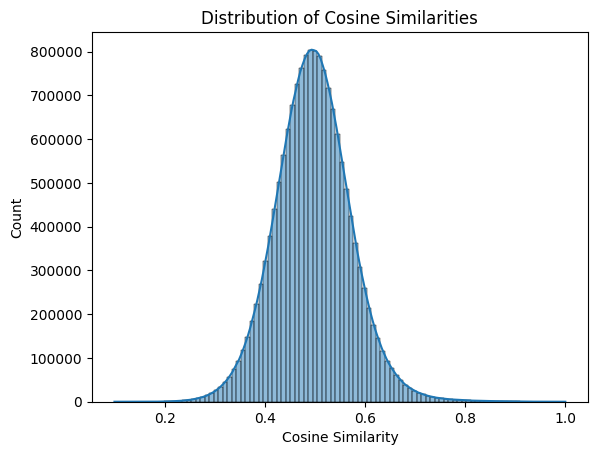

In [ ]:
def get_cosine_sim_matrix(vectors):
    """
    Get the cosine similarity matrix for the given vectors.
    """
    from sklearn.metrics.pairwise import cosine_similarity
    return cosine_similarity(vectors)
cosine_similarities = get_cosine_sim_matrix(embedding_vectors)

#choose all the lower triangular values (exclude the diagonal)
lower_triangular_indices = np.tril_indices(cosine_similarities.shape[0], k=-1)
lower_triangular_values = cosine_similarities[lower_triangular_indices]

#describe the distribution of the cosine similarities
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(lower_triangular_values, bins=100, kde=True)
plt.title("Distribution of Cosine Similarities")
plt.xlabel("Cosine Similarity")

The above histogram shows that the dataset contains fairly similar images, with most of the images having a cosine similarity of around 0.5. This makes sense, as the overall compositions of the images are similar, with most of the images containing faces in similar poses and lighting conditions. However, it's still better to filter out the images that are too similar, as they do not add much diversity to the dataset.


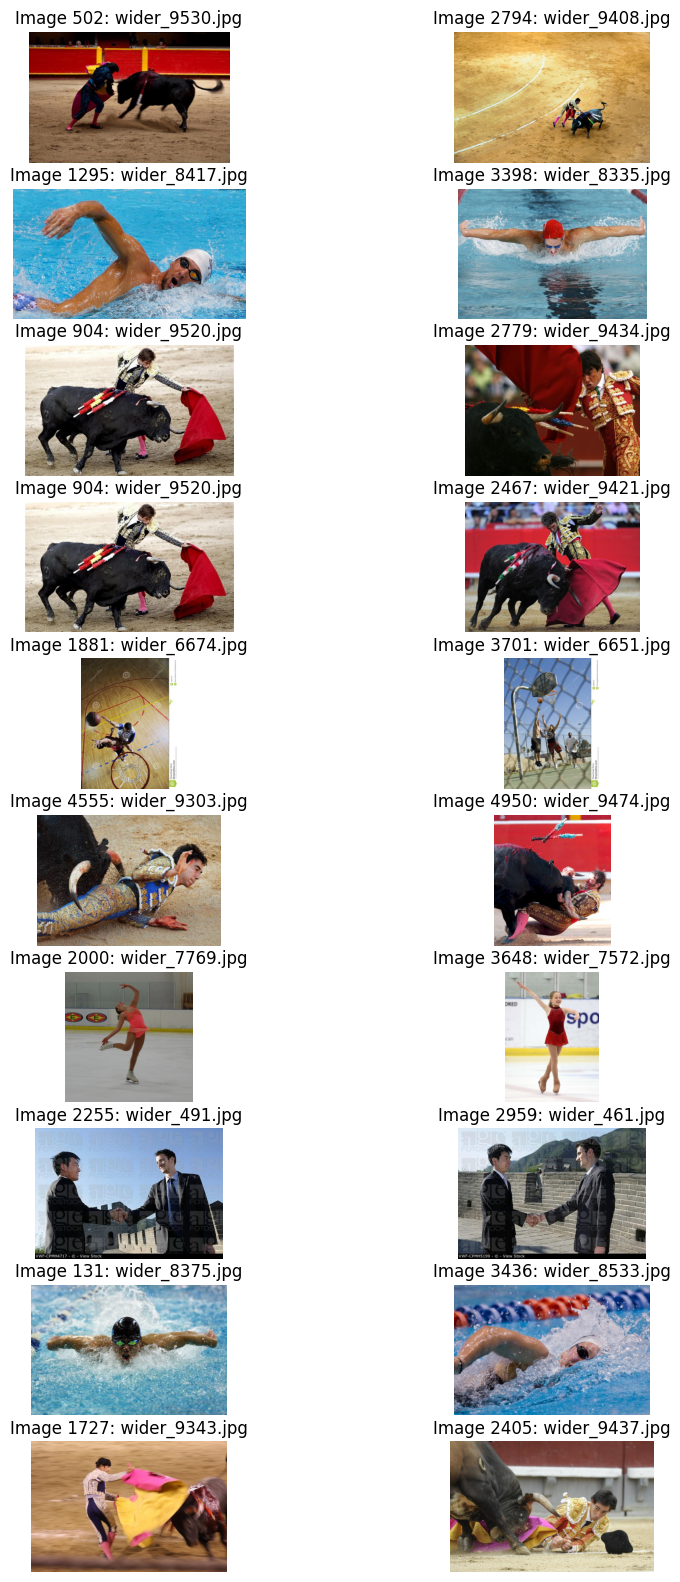

In [ ]:
similarity_mask = cosine_similarities >0.9
#change the diagonal to False
np.fill_diagonal(similarity_mask, False)
similarity_mask = similarity_mask.astype(int)
#get the indices of the images that are True in the mask as [i,j] pairs
indices = np.argwhere(similarity_mask)

#get unique pairs of indices
unique_pairs = set()
for i, j in indices:
    unique_pairs.add((int(min(i, j)), int(max(i, j))))

#plot a few unique pairs of images that are similar
import random
unique_pairs = list(unique_pairs)
sample_pairs = random.sample(range(len(unique_pairs)), 10)
sample_pairs = [(unique_pairs[i][0], unique_pairs[i][1]) for i in sample_pairs]
fig, axes = plt.subplots(nrows=len(sample_pairs), ncols=2, figsize=(
    10, 2 * len(sample_pairs)), squeeze=False)


for i, (idx1, idx2) in enumerate(sample_pairs):
    img1 = Image.open(os.path.join(filtered_images, images[idx1]))
    img2 = Image.open(os.path.join(filtered_images, images[idx2]))
    
    axes[i, 0].imshow(img1)
    axes[i, 0].set_title(f"Image {idx1}: {images[idx1]}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(img2)
    axes[i, 1].set_title(f"Image {idx2}: {images[idx2]}")
    axes[i, 1].axis('off')

In [120]:

#convert it into a dict with key as the first index and value as a list of second indices
similarity_dict = {}
for i, j in unique_pairs:
    if i not in similarity_dict:
        similarity_dict[i] = []
    similarity_dict[i].append(j)
len(list(similarity_dict.keys()))

#sort similarity_dict by the keys
sorted_similarity_dict = dict(sorted(similarity_dict.items(), key=lambda item: item[0]))

images_to_remove = set()
for key, values in sorted_similarity_dict.items():
    for value in values:
        images_to_remove.add(value)


print("Number of images to remove:", len(images_to_remove))

Number of images to remove: 47


In [ ]:


#remove the images from the filtered_images and filtered_labels directories
for image_index in images_to_remove:
    image_name = image_names[image_index] + ".jpg"
    label_name = image_names[image_index] + ".txt"
    try:
        os.remove(os.path.join(filtered_images, image_name))
        os.remove(os.path.join(filtered_labels, label_name))
    except FileNotFoundError:
        pass

Overall we have removed ~20% of the images from the dataset, as they are too similar to the other images. For the current experiment, the threshold was set to be `0.85` however, a deeper analysis of similariti 